## Imports

In [2]:
import os
import pickle

import pandas as pd
import matplotlib.pyplot as plt

# Data

In [3]:
data = pd.read_csv('new_Exam_Score_Prediction.csv')

y = data['exam_score']
X = data.drop('exam_score', axis=1)

data

,age,gender,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,facility_rating,exam_difficulty,exam_score,diploma,group_study,self_study,online_videos,coaching,mixed
0,17,1,2.78,92.9,1,7.4,0,0,2,58.9,1,0,0,0,1,0
1,22,1,7.88,76.8,1,8.5,0,2,1,90.3,0,0,0,0,1,0
2,20,0,0.89,71.6,1,9.8,0,0,1,43.7,1,0,0,0,1,0
3,23,1,3.48,65.4,1,4.2,2,0,1,58.2,0,0,0,0,0,1
4,17,0,1.35,69.0,1,7.4,1,2,2,53.7,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13269,17,1,5.74,81.4,1,7.5,2,2,2,95.0,0,0,0,1,0,0
13270,19,0,3.28,73.3,1,9.5,2,2,0,93.9,0,1,0,0,0,0
13271,18,1,3.71,41.6,0,5.9,1,1,1,60.9,0,0,0,0,1,0
13272,19,1,4.60,76.3,0,6.1,2,1,1,79.0,0,0,1,0,0,0


# Models

In [4]:
PATH = 'pipes'
pipe_names = os.listdir(PATH)[:-1] #Gitignore file to not pushing the models
pipe_names = [n.strip('.pkl') for n in pipe_names]

pipes = {}

for name in pipe_names:
    with open(os.path.join(PATH, name + '.pkl'), 'rb') as f:
        pipes[name] = pickle.load(f)

pipes

{'XSB': Pipeline(steps=[('scaler', StandardScaler()),
                 ('features_selector',
                  SelectKBest(k=15,
                              score_func=<function f_regression at 0x7df853dd42c0>)),
                 ('regressor',
                  XGBRegressor(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8207886710429086, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, e...
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.0059354140207009305, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_dept

# Friedman test

## Results for testing
Bootstrap

In [4]:
import numpy as np
from sklearn.metrics import r2_score

results = {n: [] for n in pipe_names}

idx = np.arange(0, data.shape[0])
for i in range(10):
    print("Iteration:", i)
    Boot_idx = np.random.choice(idx, size=int(10e4), replace=True, p=None)
    x_boot, y_boot = X.iloc[Boot_idx], y.iloc[Boot_idx]
    for idx, model in enumerate(pipes.values()):

        model.fit(x_boot, y_boot)
        preds = model.predict(x_boot)
        score = r2_score(y_boot, preds)

        results[pipe_names[idx]].append(score)


results_df = pd.DataFrame.from_dict(results, orient='index')
results_df

,0,1,2,3,4,5,6,7,8,9
XSB,0.775271,0.999897,0.999897,0.999897,0.999897,0.999897,0.999897,0.999897,0.999897,0.999897
Tree,0.689886,0.999786,0.999792,0.999788,0.999788,0.999789,0.999792,0.999789,0.999789,0.999788
SVR,0.740546,0.996980,0.997032,0.996999,0.996993,0.997004,0.997023,0.997007,0.997005,0.997003
Forest,0.791346,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Linear,0.732416,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


KeyboardInterrupt: 

# Friedman Test

In [10]:
from scipy.stats import friedmanchisquare

# Extract the lists from the dictionary
model_results = [results[i] for i in results]

# Run the test
stat, p = friedmanchisquare(*model_results)

print(stat)
print(f"P-value: {p}")

35.287958115183265
P-value: 4.053739743857024e-07


# Nemenyi Test
We need perform another test as the p-value in fridman test is low enough to reject null hypothesis

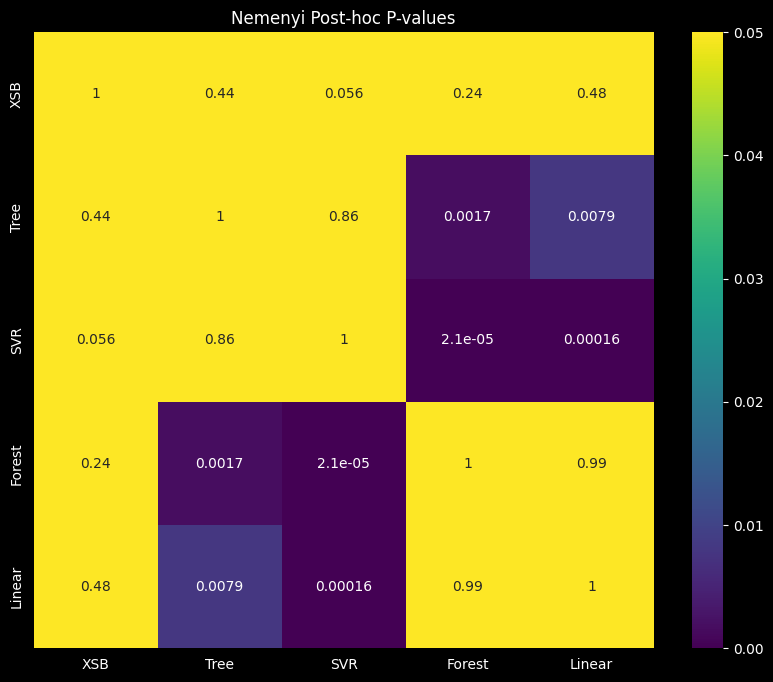

In [11]:
import scikit_posthocs as sp
import seaborn as sns

nemenyi_results = sp.posthoc_nemenyi_friedman(results_df.T)

plt.figure(figsize=(10, 8))
sns.heatmap(nemenyi_results, annot=True, cmap='viridis', vmin=0, vmax=0.05)
plt.title("Nemenyi Post-hoc P-values")
plt.show()

# Means of Model Results

In [12]:
results_df.mean(axis=1)

XSB       0.977434
Tree      0.968799
SVR       0.971359
Forest    0.979135
Linear    0.973242
dtype: float64